In [11]:
from sklearn.neighbors import KNeighborsClassifier
from fair_teacher_student_classifier import FairTeacherStudentClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [9]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


C:\Users\trdin\AppData\Local\Temp\ipykernel_22564\2974537177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('race')['class'].value_counts(normalize=True))


race                class
Amer-Indian-Eskimo  <=50K    0.882979
                    >50K     0.117021
Asian-Pac-Islander  <=50K    0.730744
                    >50K     0.269256
Black               <=50K    0.879189
                    >50K     0.120811
Other               <=50K    0.876847
                    >50K     0.123153
White               <=50K    0.746013
                    >50K     0.253987
Name: proportion, dtype: float64


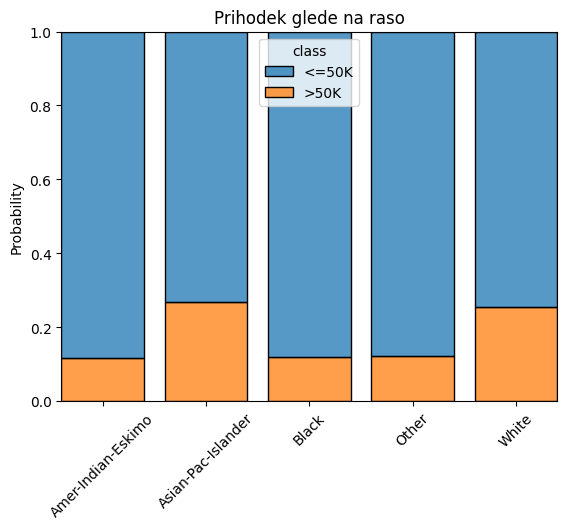

In [7]:
import matplotlib.pyplot as plt
print(df.groupby('race')['class'].value_counts(normalize=True))

sns.histplot(data=df, x='race', hue='class', stat='probability', multiple='fill', shrink=.8)
plt.title("Prihodek glede na raso")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.show()

In [12]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Train-test split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.3, random_state=42, stratify=y)


In [15]:
# Instantiate classifiers
fair_classifier = FairTeacherStudentClassifier(RandomForestClassifier)
baseline_classifier = RandomForestClassifier()

# Train classifiers
fair_classifier.fit(X_train, y_train, z_train)
baseline_classifier.fit(X_train, y_train)

# Predictions
fair_predictions = fair_classifier.predict(X_test)
baseline_predictions = baseline_classifier.predict(X_test)

In [16]:
# Compare accuracy by race
results = {}
for group in z_test.unique():
    mask = (z_test == group)
    fair_accuracy = accuracy_score(y_test[mask], fair_predictions[mask])
    baseline_accuracy = accuracy_score(y_test[mask], baseline_predictions[mask])
    results[label_encoders['race'].inverse_transform([group])[0]] = {
        'FairClassifier Accuracy': fair_accuracy,
        'Baseline Accuracy': baseline_accuracy
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                    FairClassifier Accuracy  Baseline Accuracy
White                              0.853794           0.852108
Black                              0.923182           0.927260
Other                              0.914062           0.929688
Asian-Pac-Islander                 0.819957           0.806941
Amer-Indian-Eskimo                 0.891304           0.891304
